## Internal Tides in the Tasman Sea

The Tasman Sea hosts energetic internal tides generated at the Macquarie Ridge southeast of New Zealand. This ridge system is a major source of mode-1 M₂ internal tides that radiate northwest toward the Tasmanian continental slope. These internal tide beams have been documented through satellite altimetry and mooring observations (Zhao et al., 2018; Savage et al., 2017).

We test the plane wave fit code at 155°E, 45°S, located 800 km northwest of the Macquarie Ridge in the internal tide propagation path. This notebook demonstrates the frequency-domain implementation, which applies FFT to reduce the 3D spatiotemporal fitting problem to a 2D spatial problem, achieving ~180× speedup compared to the time-domain method. We compare results from both approaches.


## MITgcm LLC4320 Simulation

We analyze output from the MITgcm LLC4320 global ocean simulation. This simulation has a horizontal resolution of 1/48° (~2 km at mid-latitudes) and 90 vertical levels with enhanced near-surface resolution. The simulation spans September 2011 through November 2012 and includes all realistic tidal forcing components, with hourly output snapshots. 

## Data Preprocessing 

While the plane wave fitting method (described in the next section) performs spectral decomposition at specified frequency (ω) and wavenumber (k), we apply preprocessing filters to better isolate the SSH signals associated with internal tides.


### Step 1: Sea surface height (SSH) in MITgcm llc4320 (June 2, 2012, 03:00 UTC)
The raw model output contains mesoscale eddies and other low-frequency variability with amplitudes of ±100 cm, which is much larger than the O(1 cm) internal tide signal we aim to extract.

<img src="../figures/notebook4_ssh_raw.png" width="600">

### Step 2: Temporally filtered SSH
We apply a 24-hour running mean filter and subtract it from the raw SSH to obtain a temporally high-pass filtered field. This removes mesoscale eddies and low-frequency variability that evolve on multi-day timescales, while preserving the semidiurnal internal tide signal (period ~12.42 hours).

<img src="../figures/notebook4_ssh_temporal_filter.png" width="600">


### Step 3: Spatially and temporally filtered SSH
We further apply a 500 km × 500 km spatial high-pass filter to remove large-scale features, including barotropic tides. This reveals the baroclinic internal tide beams radiating northwest from the Macquarie Ridge.

<img src="../figures/notebook4_ssh_spatial_temporal_filter.png" width="600">


**Note:** The preprocessing code is not included here for brevity. We begin the plane-wave fitting analysis using the preprocessed SSHA data.

The frequency-domain method first applies a Fast Fourier Transform (FFT) along the time dimension to extract the M$_2$ tidal component at each spatial location. The resulting complex spatial field at the M$_2$ frequency is then modeled as a superposition of plane-wave components:

$$
B_{M_2}(x, y)
=
\sum_{m=1}^{N}
\left[
\beta_{1,m}
\cos\!\left(
k\,x\cos\theta_m
+
k\,y\sin\theta_m
\right)
+
\beta_{2,m}
\sin\!\left(
k\,x\cos\theta_m
+
k\,y\sin\theta_m
\right)
\right].
$$

Here, $B_{M_2}$ is the complex-valued FFT coefficient at the M$_2$ frequency; $\beta_{1,m}$ and $\beta_{2,m}$ are the cosine and sine coefficients for the $m$-th component; $k$ (rad km$^{-1}$) is the horizontal wavenumber magnitude; and $\theta_m$ is the propagation direction. The amplitude of each component is given by $A_m = \sqrt{\beta_{1,m}^2 + \beta_{2,m}^2}$. Note that the temporal term ($-\omega t - \phi_m$) is absent because the FFT has already isolated the M$_2$ frequency component, reducing the 3D spatiotemporal fitting problem to a 2D spatial fitting problem.

In [7]:
from pathlib import Path
from zenodo_get import download
import utils
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import contextlib

In [8]:
# specify lat and lon
lat0 = -45
lon0 = 155

In [9]:
data_dir = Path("../data")
ssha_fn = "llc4320_ssha_tasman_155E_45S_subsample.nc"
filepath = data_dir / ssha_fn

# Try to load from repo
if filepath.exists():
    ds_ssha = xr.open_dataset(filepath)
    display(ds_ssha)
else:
    # Provide helpful error message
    github_url = f"https://github.com/youranli001/plane-wave-fit/raw/main/data/{ssha_fn}"
    raise FileNotFoundError(
        f"{ssha_fn} not found in {data_dir}.\n\n"
        f"Please download the data file:\n"
        f"1. Download from: {github_url}\n"
        f"2. Save to: {filepath.absolute()}\n\n"
        f"Or clone/download the entire repository to get all data files."
    )

<xarray.Dataset>
Dimensions:  (nx: 61, ny: 66, time: 961)
Coordinates:
    X        (nx, ny) float64 ...
    Y        (nx, ny) float64 ...
  * time     (time) datetime64[ns] 2012-05-29 2012-05-29T01:00:00 ... 2012-07-08
Dimensions without coordinates: nx, ny
Data variables:
    ssha     (nx, ny, time) float64 ...
    distX    (nx, ny) float64 ...
    distY    (nx, ny) float64 ...
    k        float64 ...
Attributes:
    title:                MITgcm LLC4320 Sea Surface Height Anomaly - Souther...
    description:          Preprocessed SSHA for internal tide analysis. Tempo...
    source:               MITgcm LLC4320
    region:               Southern Ocean (146E-170E, 54S-36S)
    center_location:      155E, 45S
    temporal_resolution:  1 hour
    temporal_filter:      24-hour running mean removed
    spatial_filter:       500km x 500km high-pass
    reference_time:       2012-05-29T00:00:00
    Conventions:          CF-1.8

In [10]:
time= utils.datetime64_to_matlab_datenum(ds_ssha['time'].values )
nt = ds_ssha.dims['time']
nx = ds_ssha.dims['nx']
ny = ds_ssha.dims['ny']


# Parameters of M2 Mode 1 Internal Tide
spdtide = 28.984104
omega = 2 * np.pi / (1.0 / spdtide * 360.0 / 24.0)  # M2 frequency rad/day # ≈12.140833 rad/day

# Expand distX and distY from (nx, ny) to (nx, ny, nt)
# time from (nt) to (nx, ny, nt)
ssha = ds_ssha['ssha'].values
k = ds_ssha['k'].values


### plane wave fit in the frequency domain

#### Prepare data

In [11]:
# Prepare time and frequency vectors
t = time - time[0]  # days, vector starting from 0
fs = 1 / (1/24)  # Sampling frequency (24 samples per day for hourly data)
f = np.arange(0, nt/2 + 1) * fs / nt  # Frequency vector [cycles/day]

# Extract 2D spatial coordinates
X_2D = ds_ssha['distX'].values  # Eastward distance [km]
Y_2D = ds_ssha['distY'].values  # Northward distance [km]



#### run func 'fit_wave_frequency_domain'

The time-domain phase indicates when the wave peaks at a reference location. The frequency-domain FFT collapses the time dimension by extracting only the M$_2$ frequency component, eliminating the temporal oscillation needed to determine when peaks occur, so temporal phase cannot be computed during this scan.

In [12]:
%%time
results_ex2 = {}

results_ex2["wave1"] = utils.fit_wave_frequency_domain(ssha, k, omega, X_2D, Y_2D, time)
max_amplitude1, max_angle1, phase1, best_predicted_wave1, residual_variances1, amplitudes1, _, uncertainty_estimates1 = results_ex2["wave1"]

results_ex2["wave2"] = utils.fit_wave_frequency_domain(ssha - best_predicted_wave1, k, omega, X_2D, Y_2D, time)
max_amplitude2, max_angle2, phase2, best_predicted_wave2, residual_variances2, amplitudes2, _, uncertainty_estimates2 = results_ex2["wave2"]

results_ex2["wave3"] = utils.fit_wave_frequency_domain(ssha - best_predicted_wave1 - best_predicted_wave2, k, omega, X_2D, Y_2D, time)
max_amplitude3, max_angle3, phase3, best_predicted_wave3, residual_variances3, amplitudes3, _, uncertainty_estimates3 = results_ex2["wave3"]


CPU times: total: 4.86 s
Wall time: 3.54 s


## plane wave fit in the time domain

#### prepare data

In [13]:
X_3D = np.repeat(ds_ssha['distX'].values[:, :, np.newaxis], nt, axis=2)
Y_3D = np.repeat(ds_ssha['distY'].values[:, :, np.newaxis], nt, axis=2)
T_3D = np.repeat(np.repeat(time[np.newaxis, np.newaxis, :], nx, axis=0), ny, axis=1)


#### run func 'fit_wave'

In [17]:
%%time
results_ex1 = {}
results_ex1["wave1"] = utils.fit_wave(ssha, k, omega, X_3D, Y_3D, T_3D, display_process=False)
max_amplitude1, max_angle1, phase1, best_predicted_wave1, residual_variances1, amplitudes1, phases1, uncertainty_estimates1 = results_ex1["wave1"]

results_ex1["wave2"] = utils.fit_wave(ssha - best_predicted_wave1, k, omega, X_3D, Y_3D, T_3D, display_process=False)
max_amplitude2, max_angle2, phase2, best_predicted_wave2, residual_variances2, amplitudes2, phases2, uncertainty_estimates2 = results_ex1["wave2"]

results_ex1["wave3"] = utils.fit_wave(ssha - best_predicted_wave1 - best_predicted_wave2, k, omega, X_3D, Y_3D, T_3D, display_process=False)
max_amplitude3, max_angle3, phase3, best_predicted_wave3, residual_variances3, amplitudes3, phases3, uncertainty_estimates3 = results_ex1["wave3"]

CPU times: total: 6min 54s
Wall time: 4min 16s


### Comparison: Time-Domain vs Frequency-Domain Plane-Wave Fitting



### Time-Domain Method (Figure 1)
The time-domain method scans all 360 compass directions, fitting the full spatiotemporal plane wave $\eta(x, y, t) = A \cos(k_x x + k_y y - \omega t - \phi)$ at each angle. This requires 360 3D fits (across space x, y and time t). The temporal term ($-\omega t$) uniquely identifies the wave propagation direction, producing **single-peaked** polar plots. This method works with any temporal sampling (regular or irregular) but is computationally expensive for large datasets.

In [14]:
angles_degrees = np.arange(1, 361)
angles_radians = np.radians(angles_degrees)
colors = ['red', 'blue', 'black']

def plot_example(results_ex, title=""):
    # unpack from stored results: [max_amplitude, max_angle, phase, best_predicted_wave, residual_variances, amplitudes, phases, uncertainty_estimates]
    amplitudes_mm = [results_ex[f"wave{i}"][5] for i in (1, 2, 3)]  
    max_angles_deg = [results_ex[f"wave{i}"][1] for i in (1, 2, 3)]      # degrees

    fig, axs = plt.subplots(1, 3, subplot_kw={'polar': True}, figsize=(15, 5))
    if title:
        fig.suptitle(title, fontsize=18, y=1.02)

    for i in range(3):
        ax = axs[i]
        amp = amplitudes_mm[i]
        color = colors[i]

        ax.plot(angles_radians, amp, color=color, linewidth=3)

        ax.set_theta_zero_location('E')
        ax.set_theta_direction(1)

        ax.tick_params(axis='x', labelsize=18)  # angular labels
        ax.tick_params(axis='y', labelsize=16)  # radial labels

        # Arrow direction
        arrow_angle_deg = max_angles_deg[i] % 360
        arrow_angle_rad = np.deg2rad(arrow_angle_deg)

        idx = int(round(arrow_angle_deg)) % 360
        arrow_length = amp[idx]

        ax.annotate(
            '',
            xy=(arrow_angle_rad, arrow_length),
            xytext=(0, 0),
            arrowprops=dict(facecolor=color, edgecolor=color, width=4, headwidth=12)
        )

        ax.set_title(f"wave{i+1}", fontsize=16, pad=18)

    plt.tight_layout()
    plt.show()

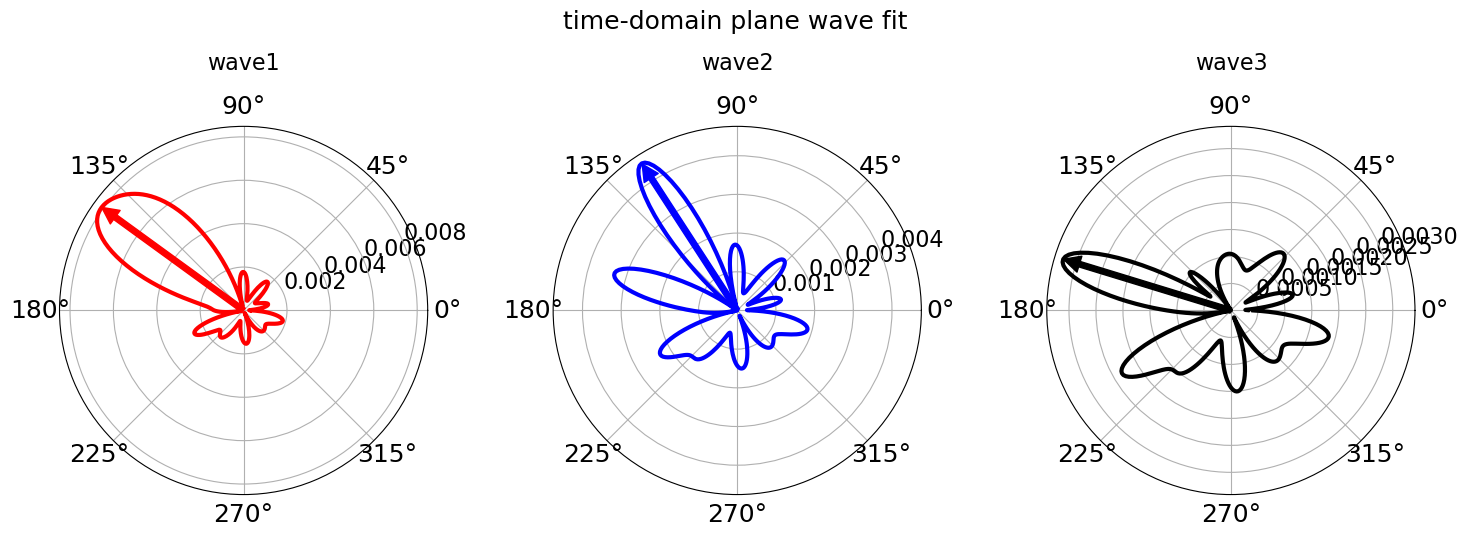

In [18]:
plot_example(results_ex1, title="time-domain plane wave fit")

### Frequency-Domain Method (Figure 2)

The frequency-domain method uses a two-stage hybrid approach for computational efficiency. **Step 1** applies FFT along the time dimension to extract the M₂ frequency component at each spatial location, yielding a complex-valued spatial field that represents the M₂ tidal component. We then perform 360 spatial fits (one per compass direction from 1° to 360°) by fitting $B_{M_2}(x, y) = \beta_1 \cos(k_x x + k_y y) + \beta_2 \sin(k_x x + k_y y)$ at each angle. The resulting amplitude at each direction tells us how strongly the spatial SSH pattern matches a wave traveling in that particular direction.

The amplitudes shown in the polar plots represent the raw directional scan results from Step 1. Their magnitude is significantly larger (e.g., 3m vs. the physical 0.008 m) because they represent unnormalized spectral strength. During this scanning stage, the values are not yet divided by the number of time samples.

Step 1 produces **two-lobe** polar plots because waves at angles θ and θ+180° create identical spatial patterns—the FFT magnitude alone cannot distinguish propagation direction. **Step 2** resolves this 180° ambiguity by testing both candidate directions (θ and θ+180°) in the time domain and selecting the direction with larger amplitude. This two-stage approach is ~180× faster than pure time-domain fitting but requires evenly-spaced time samples.

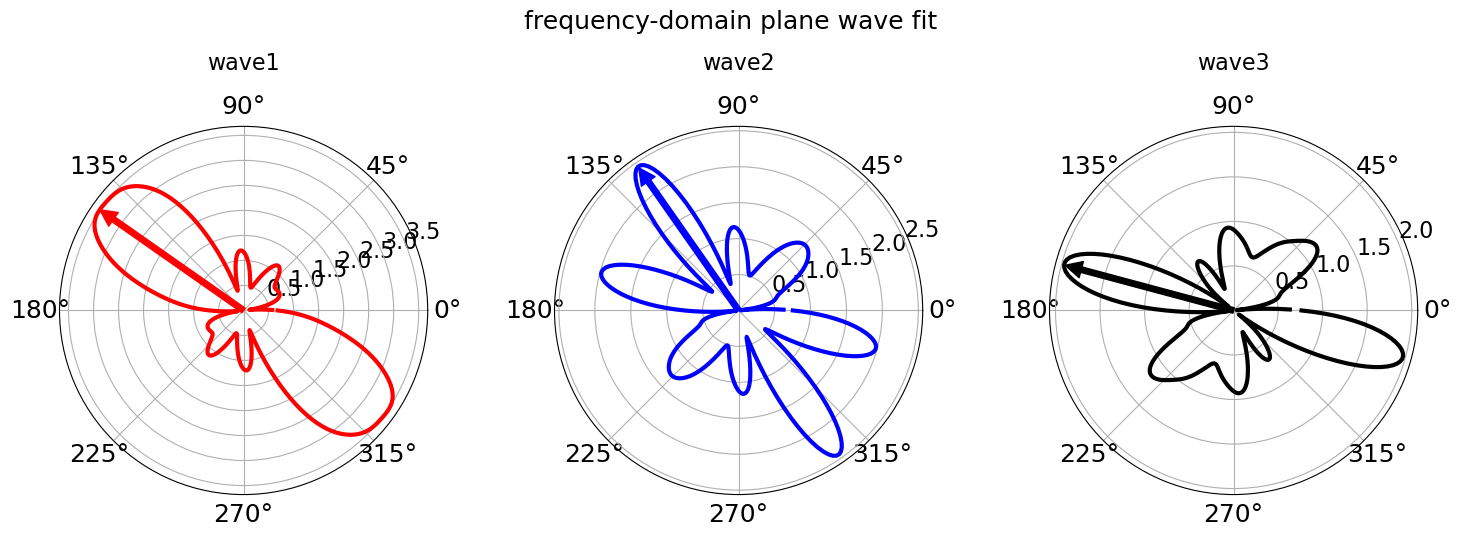

In [16]:
plot_example(results_ex2, title="frequency-domain plane wave fit")

### Extracted Wave Parameters

Both methods successfully extract three wave components with consistent results. Propagation direction is measured counterclockwise from east (0°).

In [22]:
def display_results_table(results_ex, title=""):
    # Extract per-wave quantities directly from the dict
    max_amplitudes = []
    max_angles = []
    phases_deg = []

    for i in [1, 2, 3]:
        max_amp, max_ang, phase, *_ = results_ex[f"wave{i}"]

        max_amplitudes.append(1e3 * max_amp)  # m -> mm
        max_angles.append(max_ang)
        phases_deg.append(((np.degrees(phase) + 180) % 360) - 180)

    tbl = {
        "Parameter": ["Amplitude (mm)", "Propagation direction (deg)", "Phase (deg)"],
        "Wave 1": [max_amplitudes[0], max_angles[0], phases_deg[0]],
        "Wave 2": [max_amplitudes[1], max_angles[1], phases_deg[1]],
        "Wave 3": [max_amplitudes[2], max_angles[2], phases_deg[2]],
    }

    df = pd.DataFrame(tbl).set_index("Parameter")

    if title:
        print(title)
    display(df.round(2))


display_results_table(results_ex1, title="time-domain plane wave fit")
display_results_table(results_ex2, title="frequency-domain plane wave fit")

time-domain plane wave fit


,Wave 1,Wave 2,Wave 3
Parameter,,,
Amplitude (mm),8.09,4.53,3.25
Propagation direction (deg),144.00,123.00,163.00
Phase (deg),-103.16,-123.76,-65.05


frequency-domain plane wave fit


,Wave 1,Wave 2,Wave 3
Parameter,,,
Amplitude (mm),8.08,4.76,2.98
Propagation direction (deg),145.00,125.00,165.00
Phase (deg),-101.83,-124.69,-61.37
